# Federated Learning + Linear Quantization for RESNET18 & CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [2]:
epoch = 5
rounds = 30#40#25
num_clients = 10
lrn_rate = 0.1
clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size = 32 #128
eval_batch_size= 32 #256
quantize_bits = 4
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [3]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified



- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [4]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]


# Define the criterion, and pair of optimizers for global model
The first optimizer holds the regular weights, while the second one holds the quantized parameters, which are to be propagated to the clients.

In [5]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=lrn_rate,
                                       weight_decay=5e-4)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

# ----Optimizer for quantized model on global model----
# Copy the parameters
all_G_kernels = [kernel.data.clone().requires_grad_(True)
                for kernel in global_optimizer.param_groups[1]['params']]

kernels = [{'params': all_G_kernels}]

# New optimizer for the quantized weights
goptimizer_quant = optim.SGD(kernels, lr=0)





## Define optimizers for the clients.
Each clients has a pair of optimizers

In [6]:

optimizers = [get_model_optimizer(model,learning_rate=lrn_rate, weight_decay=5e-4) for model in client_models]


optimizers_quant = []
for optimizer in optimizers:
    # Copy the parameters
    all_G_kernels = [kernel.data.clone().requires_grad_(True)
                    for kernel in optimizer.param_groups[1]['params']]

    # Handle of the optimizer parameters
    all_W_kernels = optimizer.param_groups[1]['params']
    kernels = [{'params': all_G_kernels}]

    # New optimizer for the quantized weights
    optimizer_quant = optim.SGD(kernels, lr=0)
    optimizers_quant.append(optimizer_quant)


In [7]:
server_test = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(evaluate_model)

In [8]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer
        print(f"Client {client} training")
        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             optimizer_quant = optimizers_quant[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate in 2 steps
    server_aggregate(global_model, client_models)
    server_quantize(global_optimizer, goptimizer_quant, quantize_bits)

    # Test the global model
    test_loss, test_acc = server_test(model=global_model,
                                      test_loader=test_loader,
                                      device=device,
                                      criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

Client 0 training
Epoch: 0/1 Train Loss: 0.002 Train Acc: 0.000


 20%|██        | 1/5 [00:10<00:42, 10.70s/it]

0-th ROUND: average train loss 0.00159 | test loss 2.31 | test acc: 0.101
Client 0 training
Epoch: 0/1 Train Loss: 0.003 Train Acc: 0.000


 40%|████      | 2/5 [00:15<00:21,  7.31s/it]

1-th ROUND: average train loss 0.00276 | test loss 2.33 | test acc: 0.100
Client 0 training
Epoch: 0/1 Train Loss: 0.006 Train Acc: 0.000


 60%|██████    | 3/5 [00:20<00:12,  6.25s/it]

2-th ROUND: average train loss 0.0062 | test loss 3.07 | test acc: 0.100
Client 0 training
Epoch: 0/1 Train Loss: 0.004 Train Acc: 0.000


 80%|████████  | 4/5 [00:25<00:05,  5.72s/it]

3-th ROUND: average train loss 0.00423 | test loss 3.22e+03 | test acc: 0.100
Client 0 training
Epoch: 0/1 Train Loss: 0.006 Train Acc: 0.000


100%|██████████| 5/5 [00:30<00:00,  6.10s/it]

4-th ROUND: average train loss 0.00608 | test loss 1.45e+04 | test acc: 0.100


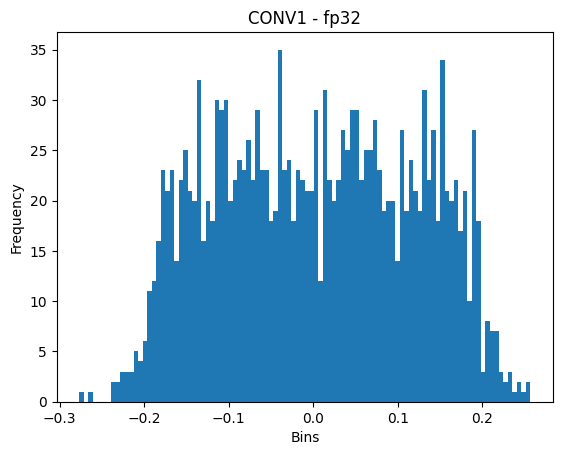

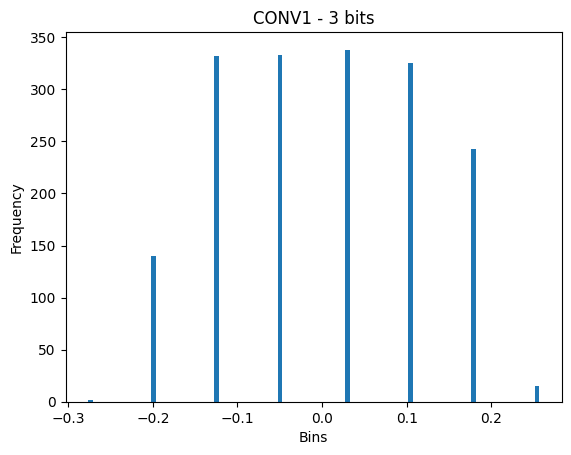

In [9]:
quantized_histogram = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(histogram_conv1)

# Evaluate the model's histogram
before = histogram_conv1(global_model)
plot_histogram(before[0], before[1],f"CONV1 - fp32")


after = quantized_histogram(global_model)
plot_histogram(after[0], after[1], f"CONV1 - {quantize_bits} bits")


In [10]:
print(before[1].shape, "\n",after[1].shape)

torch.Size([101]) 
 torch.Size([101])


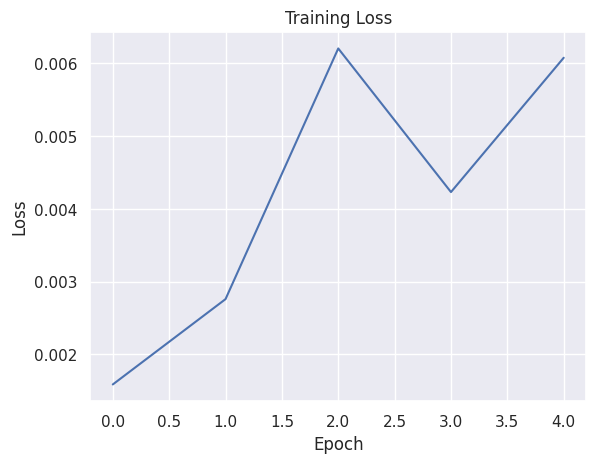

In [11]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

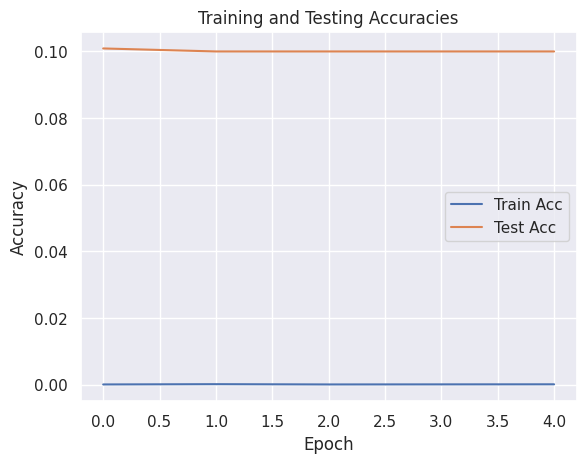

In [13]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = server_test(global_model, test_loader, device,criterion=criterion)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 14458.1361984375, Accuracy: 9.999999046325684%
44.77 MB
CPU Inference Latency: 11.70 ms / sample
CUDA Inference Latency: 3.10 ms / sample


In [15]:
save_model(global_model, "saved_models", f'resnet_fedlern_global_{time_stamp()}.pth')


In [16]:
save_quantized_model = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(save_model)
save_quantized_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')